# Cross Validation and Grid Search

Here are examples of cross validation (running the same model with different training sets to get statistics on the performance) and grid search (trying an exhaustive search in parameter space.)

In [185]:
from sklearn.datasets import fetch_openml

In [186]:
# Try this -- it may get blocked by LCPS?

# uncomment next line
# mnist = fetch_openml('mnist_784', as_frame=False)

In [188]:
# if above doesn't work, do this.
# first download and gunzip the file from github "mnist.gzip"

# infile = open("mnist.pk", "rb")
# mnist = pickle.load(infile)

In [189]:
X,y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

In [190]:
from sklearn.model_selection import train_test_split

Note we use a subset of the data!

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.01, train_size=0.1)

In [192]:
X_train.shape, X_test.shape

((7000, 784), (700, 784))

Let's make a binary classifier first : "5" or "not 5"

In [193]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

SGD (standard gradient descent) is a type of linear classifier that minimizes a loss function. We use it here just because it's different.

In [194]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [195]:
sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [196]:
y_pred = sgd_classifier.predict(X_test)

In [197]:
accuracy_score(y_pred, y_test_5)

0.9471428571428572

Now we try cross validation -- it runs the same model training with 5 different subsets of the training set. It validates it on the remainder. This is called k-fold validation. (you can change the 5)

In [198]:
from sklearn.model_selection import cross_val_score

In [199]:
cross_val_score(sgd_classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.91714286, 0.95142857, 0.95642857, 0.95785714, 0.95214286])

As an example we do a KNN also

In [200]:
from sklearn.neighbors import KNeighborsClassifier

In [201]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train_5)

KNeighborsClassifier(n_neighbors=7)

In [202]:
cross_val_score(knn_classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.98714286, 0.98785714, 0.98071429, 0.98428571, 0.98928571])

KNN can do multiclass, so let's throw the 10-class original training set at it.

In [203]:
cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring="accuracy")

array([0.92785714, 0.94214286, 0.915     , 0.92857143, 0.92857143])

Let's look at some statistics. We'll run it 20 times and use a pandas dataset as a quick way to get stats.

In [204]:
knn_results = cross_val_score(knn_classifier, X_train, y_train, cv=20, scoring="accuracy")

In [205]:
import pandas as pd

In [206]:
pd.Series(knn_results).describe()

count    20.000000
mean      0.932714
std       0.010466
min       0.914286
25%       0.927857
50%       0.931429
75%       0.937143
max       0.954286
dtype: float64

## Grid Search

A grid search takes a list of parameters and does a cross-validation on each parameter. It is a slow, exhaustive way to find the best setting for your model.

In [209]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Define parameter grid
param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=1)

# Print the grid_search to confirm no errors
print(grid_search)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               10, 15, 20, 25,
                                                               30]},
             scoring='accuracy')


In [210]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               10, 15, 20, 25,
                                                               30]},
             scoring='accuracy')

We'll do lots of analysis on these results. The final best model is below.

In [213]:
knn_cv_results = pd.DataFrame(grid_search.cv_results_)

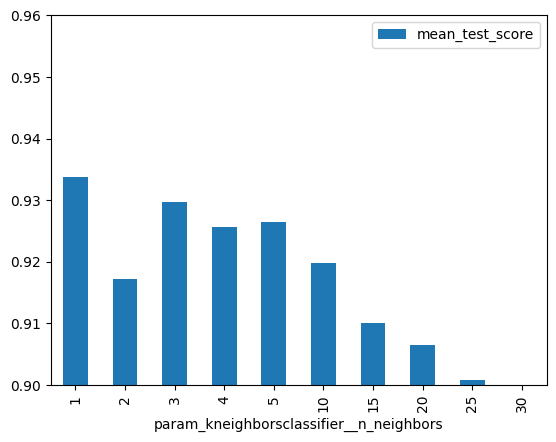

In [214]:
knn_cv_results.plot(x='param_kneighborsclassifier__n_neighbors', y='mean_test_score',
                   kind='bar',ylim=(0.9,0.96));

In [215]:
knn_cv_results.sort_values(by="mean_test_score", ascending = False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.008094      0.000404         0.331692        0.013044   
2       0.007854      0.000286         0.441001        0.090881   
4       0.007764      0.000423         0.346311        0.010852   
3       0.009060      0.001003         0.409770        0.098917   
5       0.007390      0.000223         0.327227        0.004433   
1       0.008793      0.001301         0.333124        0.016238   
6       0.007868      0.000141         0.379707        0.056234   
7       0.007594      0.000229         0.359337        0.039604   
8       0.007759      0.000049         0.327107        0.002920   
9       0.007628      0.000327         0.327724        0.004928   

   param_kneighborsclassifier__n_neighbors  \
0                                        1   
2                                        3   
4                                        5   
3                                        4   
5                                       10   
1                                        2   
6                                       15   
7                                       20   
8                                       25   
9                                       30   

                                      params  split0_test_score  \
0   {'kneighborsclassifier__n_neighbors': 1}           0.928877   
2   {'kneighborsclassifier__n_neighbors': 3}           0.931877   
4   {'kneighborsclassifier__n_neighbors': 5}           0.931877   
3   {'kneighborsclassifier__n_neighbors': 4}           0.931020   
5  {'kneighborsclassifier__n_neighbors': 10}           0.923308   
1   {'kneighborsclassifier__n_neighbors': 2}           0.912596   
6  {'kneighborsclassifier__n_neighbors': 15}           0.917738   
7  {'kneighborsclassifier__n_neighbors': 20}           0.912596   
8  {'kneighborsclassifier__n_neighbors': 25}           0.908740   
9  {'kneighborsclassifier__n_neighbors': 30}           0.898029   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.931847           0.940420         0.933715        0.004894   
2           0.923275           0.933991         0.929714        0.004634   
4           0.919417           0.927990         0.926428        0.005205   
3           0.917703           0.928418         0.925714        0.005763   
5           0.911273           0.924989         0.919857        0.006108   
1           0.915988           0.922846         0.917144        0.004263   
6           0.898843           0.913416         0.909999        0.008084   
7           0.899700           0.906987         0.906428        0.005280   
8           0.890699           0.903129         0.900856        0.007539   
9           0.883412           0.896700         0.892714        0.006600   

   rank_test_score  
0                1  
2                2  
4                3  
3                4  
5                5  
1                6  
6                7  
7                8  
8                9  
9               10

In [216]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'kneighborsclassifier__n_neighbors': 1}


In [217]:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

Best Model: Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])


In [218]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy with Best Model:", accuracy)

Test accuracy with Best Model: 0.9328571428571428
